In [14]:
from datetime import date, timedelta
from constants import *
from phe import plot_areas, recent_phe_data_summed, map_data as phe_map_data, best_data
from zoe import latest_map_data as zoe_map_data
from plotting import matplotlib_zoe_vs_phe_map, geoplot_bokeh, save_to_disk, bokeh_zoe_vs_phe_map
for_date = '*'

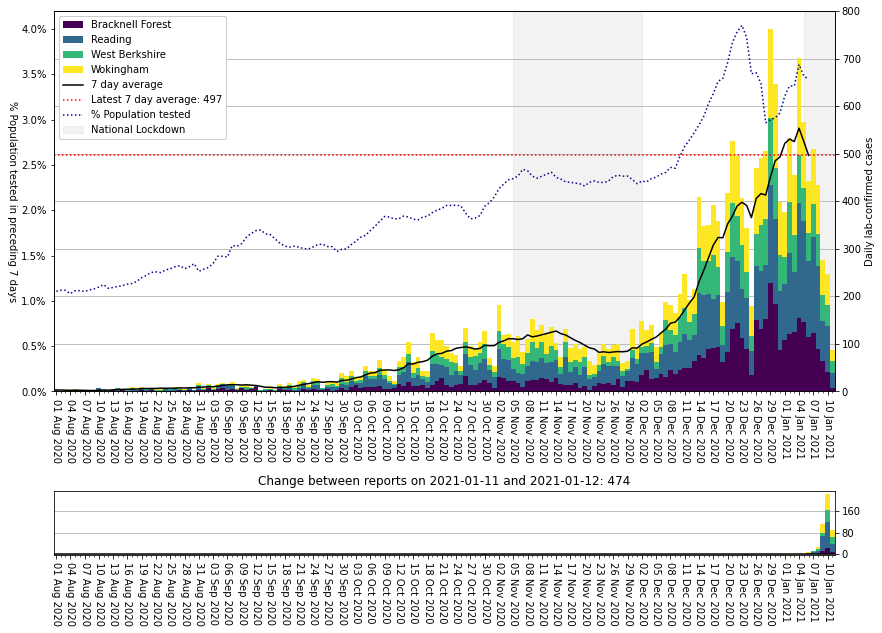

In [15]:
plot_areas(for_date, areas=my_areas)

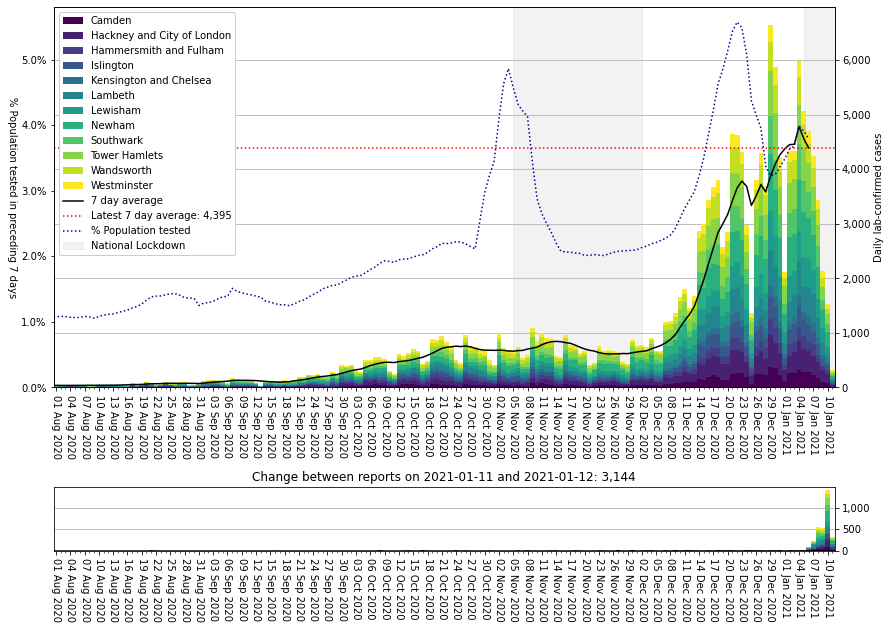

In [16]:
plot_areas(for_date, areas=london_areas)

In [17]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [18]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"cases per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000011,Knowsley,1147.406239,1731.0,2021-01-11
E09000002,Barking and Dagenham,1041.774304,2218.0,2021-01-11
E09000025,Newham,998.487826,3526.0,2021-01-11
E06000006,Halton,933.467275,1208.0,2021-01-11
E08000014,Sefton,884.555552,2445.0,2021-01-11
E07000073,Harlow,872.890992,760.0,2021-01-11
E06000034,Thurrock,872.428172,1521.0,2021-01-11
E06000039,Slough,855.963996,1280.0,2021-01-11
E09000026,Redbridge,852.166620,2601.0,2021-01-11


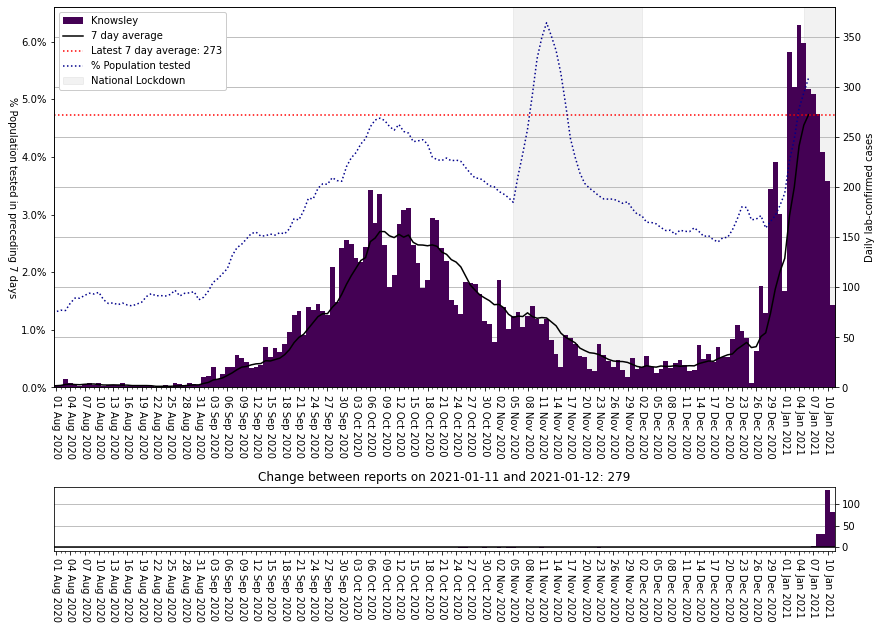

In [19]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [20]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"cases per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,598.345092,6832.0,2021-01-11
E08000012,Liverpool,831.656768,4142.0,2021-01-11
E09000025,Newham,998.487826,3526.0,2021-01-11
E09000008,Croydon,728.970029,2819.0,2021-01-11
E09000009,Ealing,817.130185,2793.0,2021-01-11
E09000005,Brent,824.208314,2718.0,2021-01-11
E06000058,"Bournemouth, Christchurch and Poole",674.624555,2667.0,2021-01-11
E09000003,Barnet,662.087711,2621.0,2021-01-11
E09000026,Redbridge,852.166620,2601.0,2021-01-11


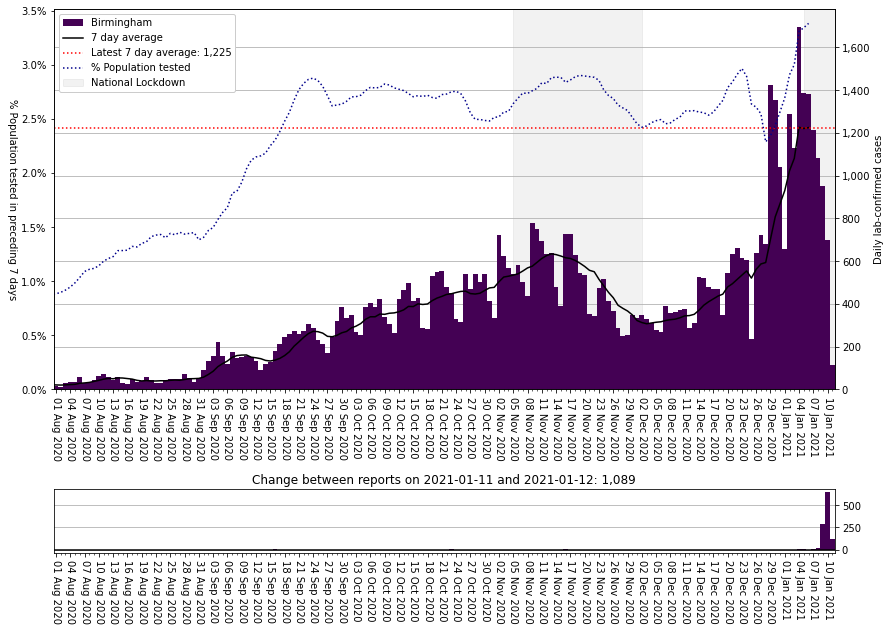

In [21]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [22]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)

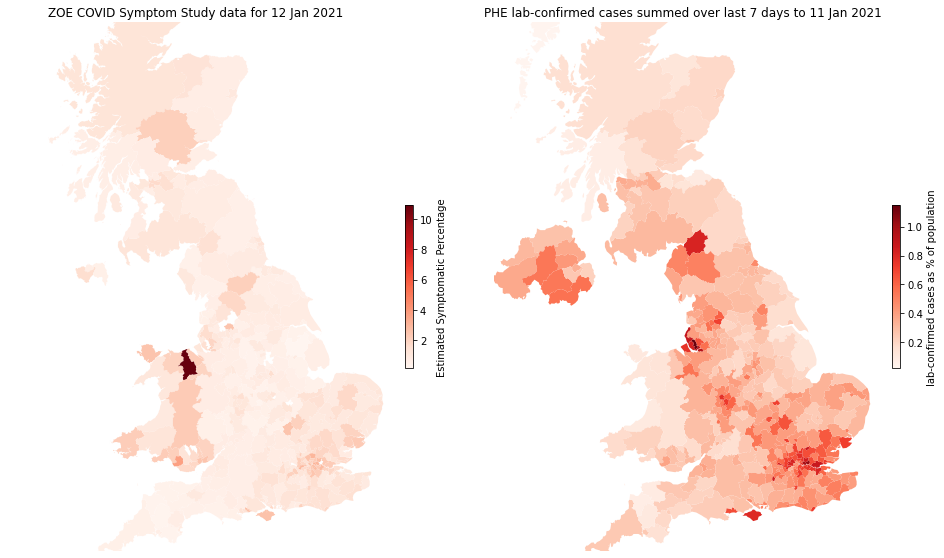

In [23]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)   

In [24]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)

Loading BokehJS ...

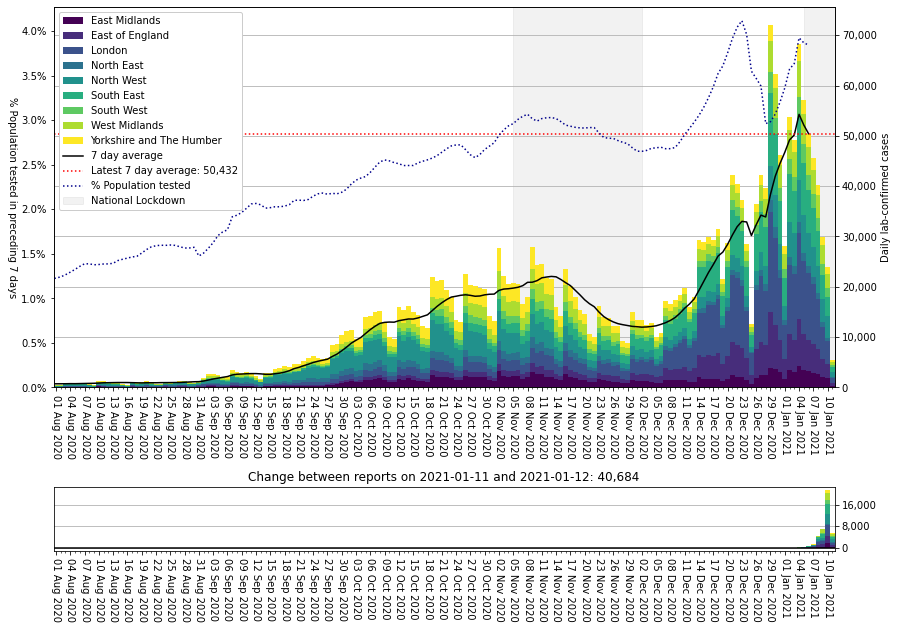

In [25]:
plot_areas(for_date, area_type=region)

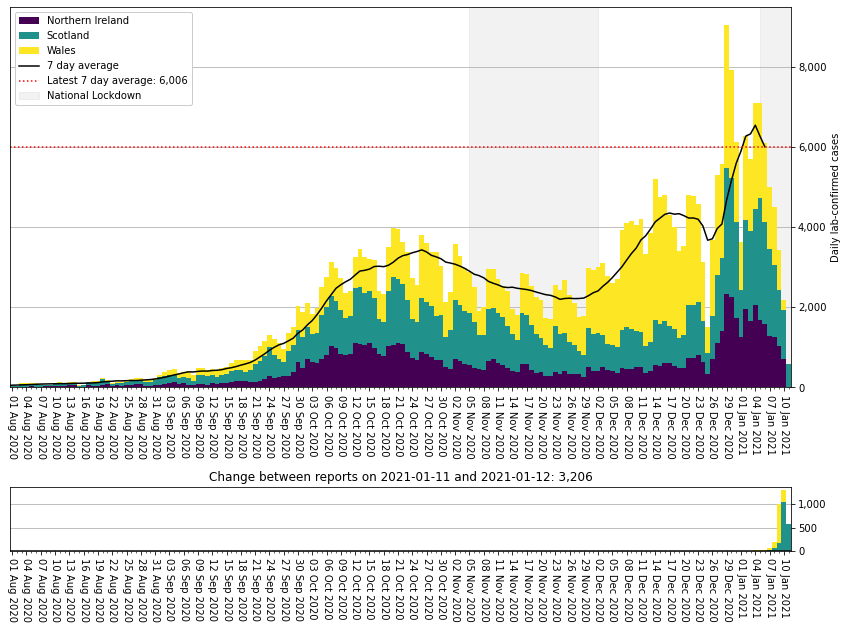

In [26]:
plot_areas(for_date, area_type=nation, areas=[scotland, northern_ireland, wales], show_testing=False)